In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import dates as mpl_dates

%matplotlib inline


In [2]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [13]:
def plot_series(x, y, fomat = '-', start = 0, end = None, figsize = (10, 6), truncate= 500,
               rotation = 0, xlabel = None, ylabel = None, legend = None, title= None):
    """
    Visualizes a time series
    
    Args:
    x (array of int) - contains values of x axis
    y (array of int/float or tuple of array) - contains values of y axis
    format (string) - line type of the graph
    end (int) -  time step to stop
    start (int) - begining of time step to plot
    xlabel (string) - describe the x axis
    ylabel (string) - describe the y axis
    legend (string) - legend of the plot
    title (string) - title of the plot
    figsize (tuple of int) - the figure size
    truncate (int) - ticks to label
    """
    plt.style.use('seaborn-v0_8-bright')
    fig, ax = plt.subplots(figsize = figsize)
    
    if type(y) is tuple:
        for i in y:
            ax.plot(x[start:end], i[start:end], fomat,)
    else:
        ax.plot(x[start:end], y[start:end], fomat)
        
    ax.set_xticks(x[::truncate])
    ax.set_xticklabels(x[::truncate], rotation = rotation)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if legend:
        ax.legend(legend)
        
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%b/%d/%Y')
    
    ax.xaxis.set_major_formatter(date_format)
    
    ax.set_title(title)
    ax.grid(True)
    plt.show()

In [14]:
import pandas as pd

# Read the CSV file with specified date format
df = pd.read_csv('./Sunspots.csv', header = 0, index_col= 0)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [15]:
df.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [16]:
time = df.index
data_values = df['Monthly Mean Total Sunspot Number']

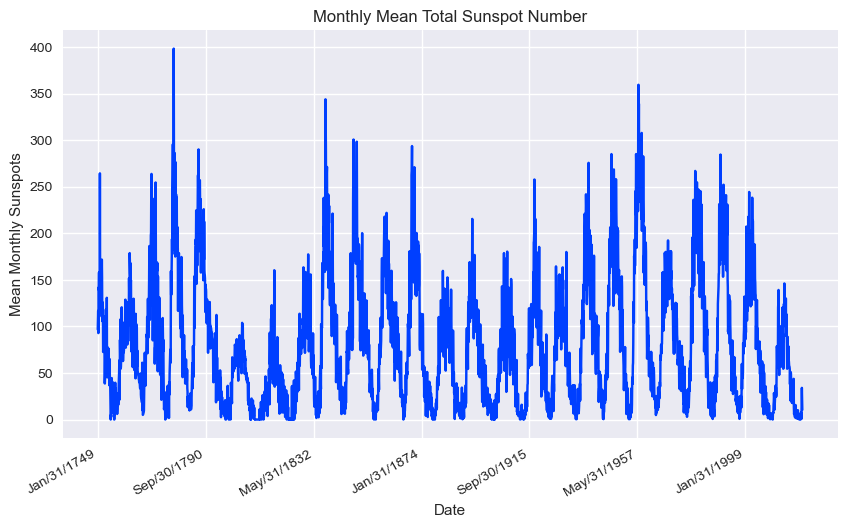

In [17]:

plot_series(time, data_values, xlabel= 'Date', ylabel= 'Mean Monthly Sunspots', title = 'Monthly Mean Total Sunspot Number', rotation=60)

In [18]:
time = np.array(time)
data_values = np.array(data_values)

In [19]:
print(0.2 * 3265)
print(3265-653)

653.0
2612


In [20]:
split = 2612

# Trainin set
train_time = time[:split]
train_data_values = data_values[:split]
# Test?Validation set
valid_time = time[split:]
valid_data_values = data_values[split:]


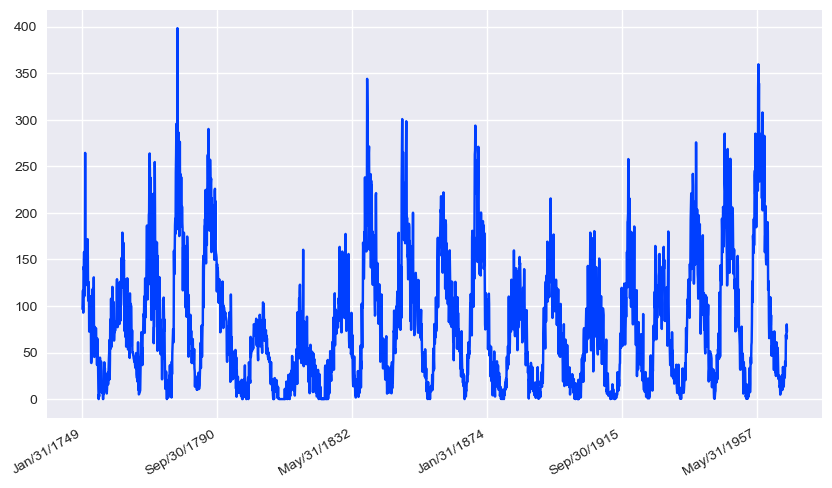

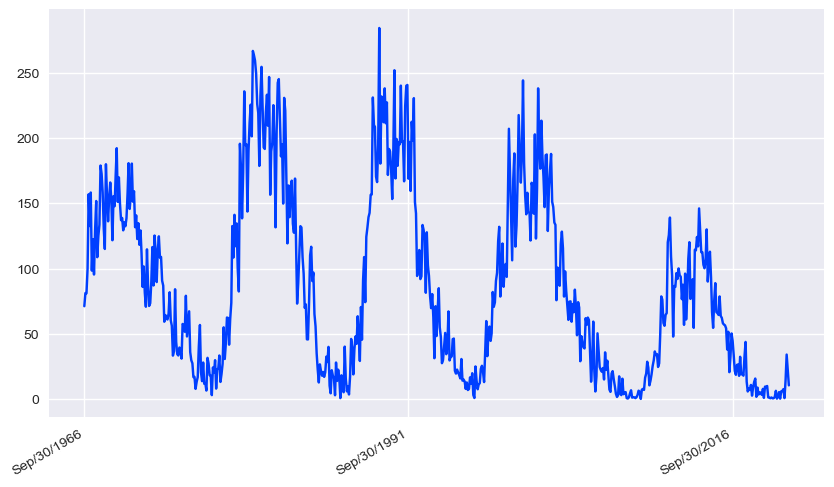

In [21]:
plot_series(train_time, train_data_values, rotation=60)

plot_series(valid_time, valid_data_values, truncate=300)

In [22]:
naive_forecast = data_values[split-1:-1]

time_step = 70

print(f'ground truth at time step: {time_step} {valid_data_values[time_step]}')
print(f'grounf truth at time step +1: {time_step + 1} {naive_forecast[time_step +1]}')


ground truth at time step: 70 108.3
grounf truth at time step +1: 71 108.3


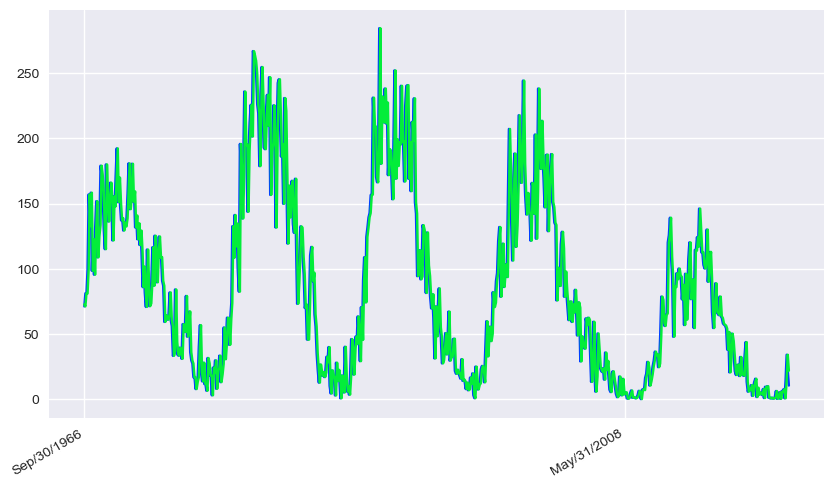

In [23]:
plot_series(valid_time, (valid_data_values, naive_forecast))


In [24]:
print(tf.keras.metrics.mean_squared_error(valid_data_values, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_data_values, naive_forecast).numpy())

636.0172128637058
18.20459418070444


In [25]:
def moving_average(series, window_size):
    """
    Calculates the moving average of a time series
    
    Args
    series (array of float) - data of series
    window_size (int) - the time steps of which to calculate the average.
    
    Return (array of float) - the forecast of the moving average
    """
    
    forecast = []
    for i in range(len(series) - window_size):
        forecast.append(series[i:i+window_size].mean())
        
    forecast =  np.array(forecast)
    
    return forecast

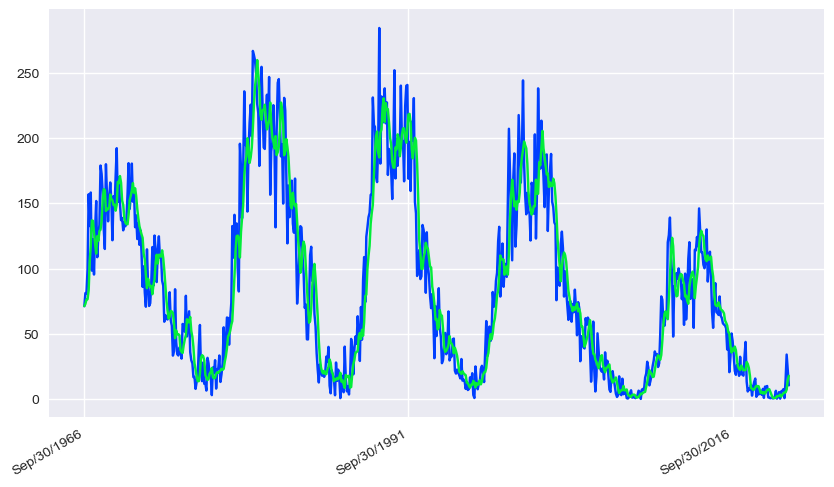

In [26]:
# after finding the optimal window 

window = 4
moving_avg = moving_average(data_values, window)[split- window:]

plot_series(valid_time, (valid_data_values, moving_avg), truncate=300)

In [27]:
print(tf.keras.metrics.mean_squared_error(valid_data_values, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_data_values, moving_avg).numpy())

603.00817381317
17.87993874425727


In [28]:
period = 507

diff_series = data_values[period:] - data_values[:-period]

diff_time = time[period:]

In [29]:
diff_series.shape
#diff_time.shape

(2758,)

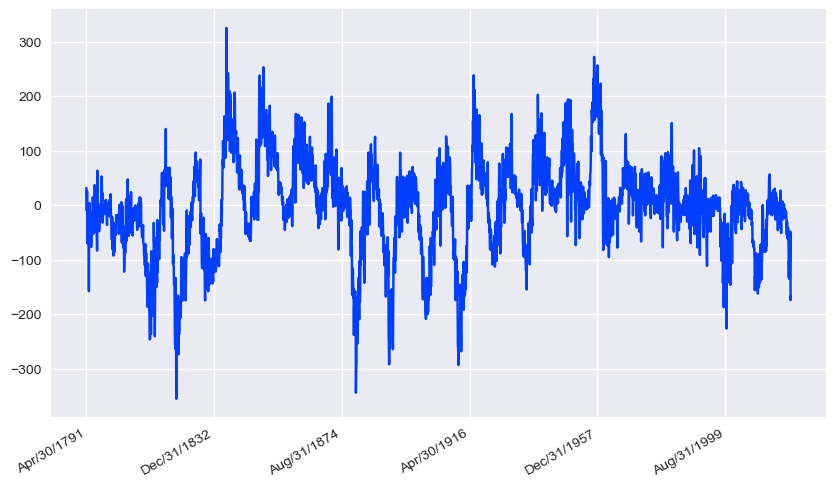

In [30]:
#3265-3133
plot_series(diff_time, diff_series, rotation=60)

In [31]:
window = 4
diff_moving = moving_average(diff_series, window)

diff_moving = diff_moving[split - period - window:]

diff_series = diff_series[split - period:]

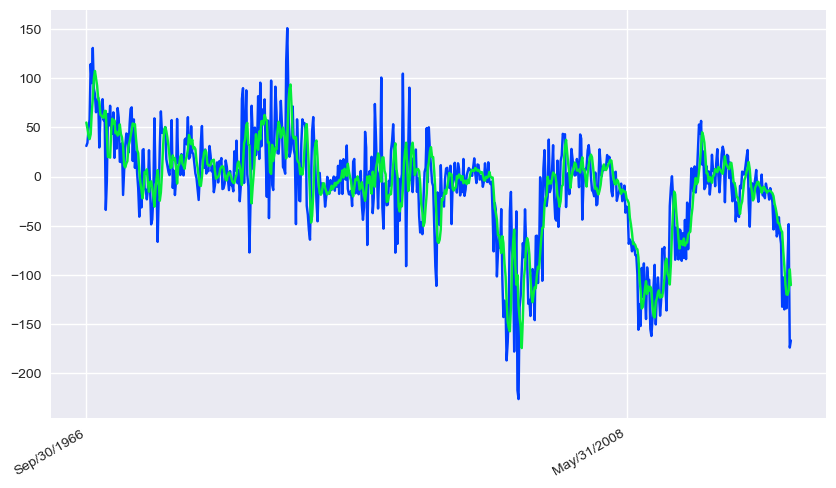

In [32]:
plot_series(valid_time, (diff_series, diff_moving))

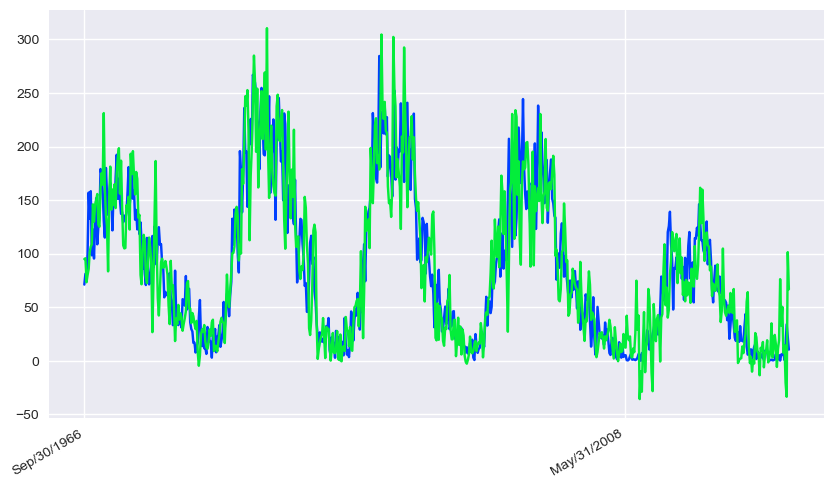

In [33]:
# bringing back the trend and seasonality
ts_diff_moving = data_values[split - period : -period] + diff_moving

plot_series(valid_time, (valid_data_values, ts_diff_moving))

In [34]:
print(tf.keras.metrics.mean_squared_error(valid_data_values, ts_diff_moving).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_data_values, ts_diff_moving).numpy())

1227.6455417304744
25.774732006125575


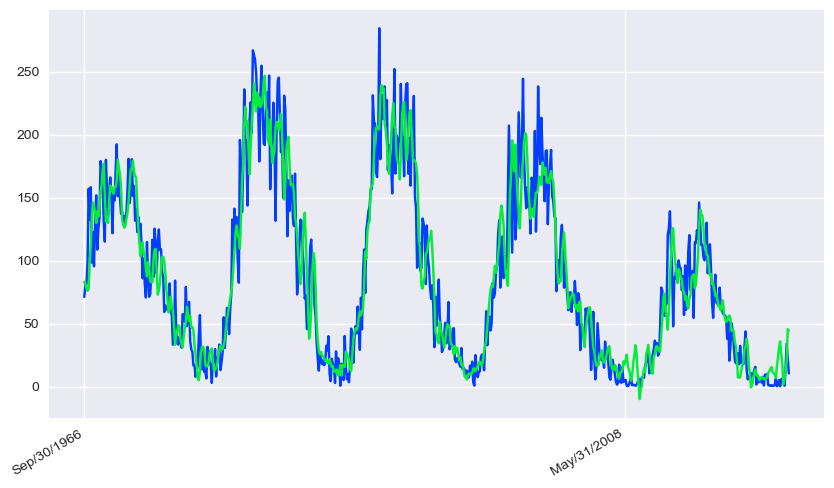

In [35]:
# After tuning th best found was 4
ts_smooth = moving_average(data_values[split - period-4:-period+4], 8) + diff_moving

plot_series(valid_time, (valid_data_values, ts_smooth))

In [36]:
print(tf.keras.metrics.mean_squared_error(valid_data_values, ts_smooth).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_data_values, ts_smooth).numpy())

656.5175227316234
18.733365237365998


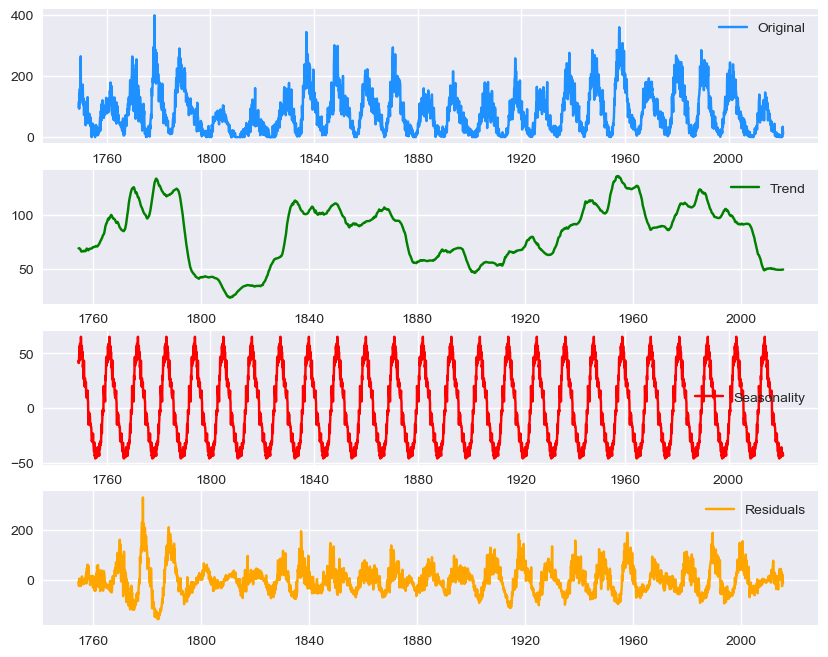

In [37]:
decompose = seasonal_decompose(df,period =132)
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
plots = [df, trend, seasonal, residual]
labels = ['Original','Trend','Seasonality', 'Residuals']
colors = ['dodgerblue', 'green', 'red', 'orange']
plt.figure(figsize=(10,8))

for i, plot in enumerate(plots):
    plt.subplot(4,1,i+1)
    plt.plot(plot, label=labels[i], color =colors[i] )
    plt.legend(loc= 'best')
    plt.tight_layout

In [ ]:
#from statsmodels.tsa.seasonal import STL
#decomposition = STL(df['Monthly Mean Total Sunspot Number']).fit()

#residual = decomposition.resid
#residual.values

In [38]:
def create_window_dataset(train, window_size, shuffle, batch_size):
    """Creates features and labels for a time series
    Args:
    train (array of float)- values of a given time step
    window_size (int)- the dimension of feature
    shuffle (int) - the size to use for shuffling
    batch_size (int) - the batch size
    
    Returns:
    dataset (tf dataset)- dataset of time steps and label
    """
    
    
    dataset = tf.data.Dataset.from_tensor_slices(train)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size +1))
    dataset = dataset.map(lambda window: (window[:-1],window[-1]))
    dataset = dataset.shuffle(shuffle)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [39]:
window_size = 30
shuffle = 1000
batch_size = 32

dataset = create_window_dataset(data_values, window_size, shuffle, batch_size)

In [40]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [41]:
init_weights = model.get_weights()

In [42]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
102/102 [==============================] - 8s 30ms/step - loss: 75.6639 - lr: 1.0000e-08
Epoch 2/100
102/102 [==============================] - 4s 36ms/step - loss: 63.9807 - lr: 1.1220e-08
Epoch 3/100
102/102 [==============================] - 6s 52ms/step - loss: 54.2584 - lr: 1.2589e-08
Epoch 4/100
102/102 [==============================] - 7s 66ms/step - loss: 47.6920 - lr: 1.4125e-08
Epoch 5/100
102/102 [==============================] - 5s 50ms/step - loss: 43.9872 - lr: 1.5849e-08
Epoch 6/100
102/102 [==============================] - 5s 50ms/step - loss: 41.5989 - lr: 1.7783e-08
Epoch 7/100
102/102 [==============================] - 4s 38ms/step - loss: 39.8443 - lr: 1.9953e-08
Epoch 8/100
102/102 [==============================] - 5s 47ms/step - loss: 38.2884 - lr: 2.2387e-08
Epoch 9/100
102/102 [==============================] - 4s 33ms/step - loss: 36.6307 - lr: 2.5119e-08
Epoch 10/100
102/102 [==============================] - 4s 32ms/step - loss: 34.7485 - lr: 

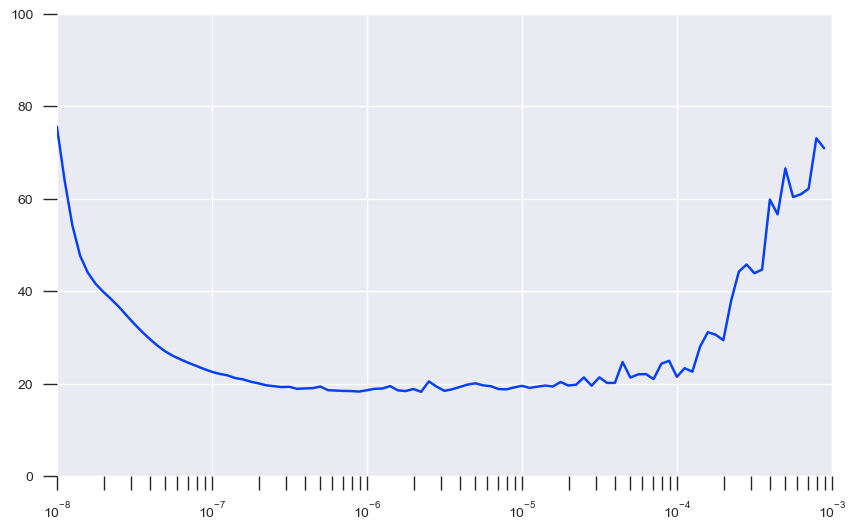

In [43]:
epochs = 100
lrs = 1e-8 * (10 ** (np.arange(epochs) / 20))

plt.figure(figsize=(10, 6))

plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

plt.grid(True)

In [44]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [45]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [46]:
history = model.fit(dataset,epochs=100)

Epoch 1/100
102/102 [==============================] - 9s 25ms/step - loss: 35.4038 - mae: 35.8994
Epoch 2/100
102/102 [==============================] - 3s 25ms/step - loss: 22.6271 - mae: 23.1214
Epoch 3/100
102/102 [==============================] - 3s 26ms/step - loss: 20.5050 - mae: 20.9975
Epoch 4/100
102/102 [==============================] - 3s 25ms/step - loss: 20.3325 - mae: 20.8262
Epoch 5/100
102/102 [==============================] - 3s 28ms/step - loss: 19.3753 - mae: 19.8680
Epoch 6/100
102/102 [==============================] - 3s 30ms/step - loss: 19.1501 - mae: 19.6443
Epoch 7/100
102/102 [==============================] - 5s 51ms/step - loss: 18.8677 - mae: 19.3609
Epoch 8/100
102/102 [==============================] - 4s 35ms/step - loss: 18.7563 - mae: 19.2488
Epoch 9/100
102/102 [==============================] - 4s 36ms/step - loss: 18.4328 - mae: 18.9255
Epoch 10/100
102/102 [==============================] - 4s 37ms/step - loss: 18.4281 - mae: 18.9199
Epoch 11/

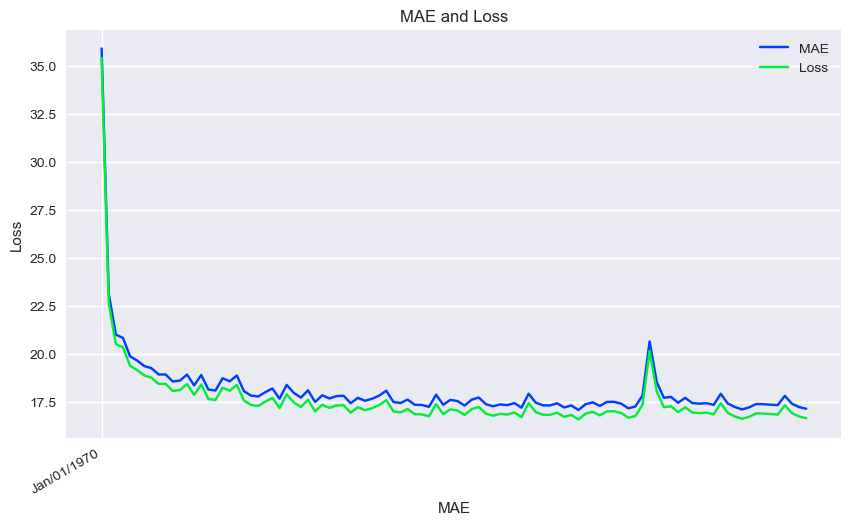

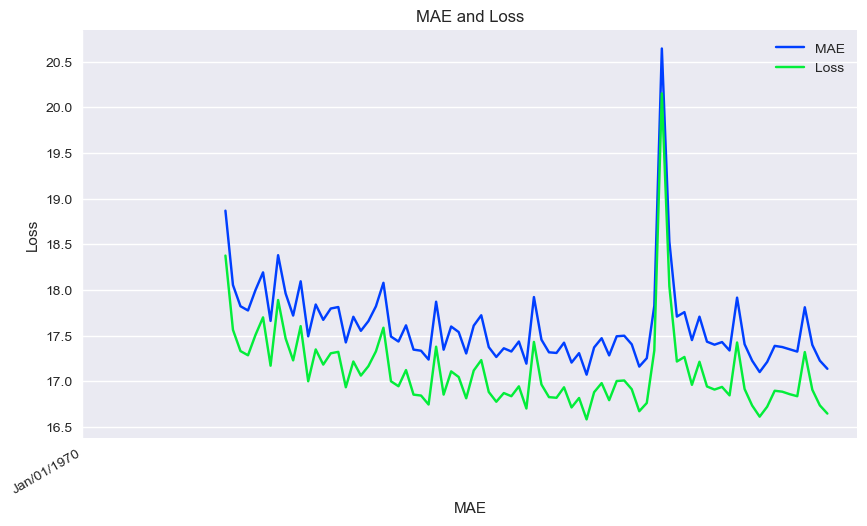

In [47]:
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom = int(epochs[-1] * 0.2)

mae_zoom = mae[zoom:]
loss_zoom = loss[zoom:]

# Plot zoomed mae and loss
plot_series(
    x=epochs,
    start = zoom,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [49]:
forecast_data = data_values[split - window_size:]
forecast = []
for time in range(len(forecast_data) - window_size):
    forecast.append(model.predict(forecast_data[time:time + window_size][np.newaxis]))

1/1 [==============================] - 0s 38ms/step


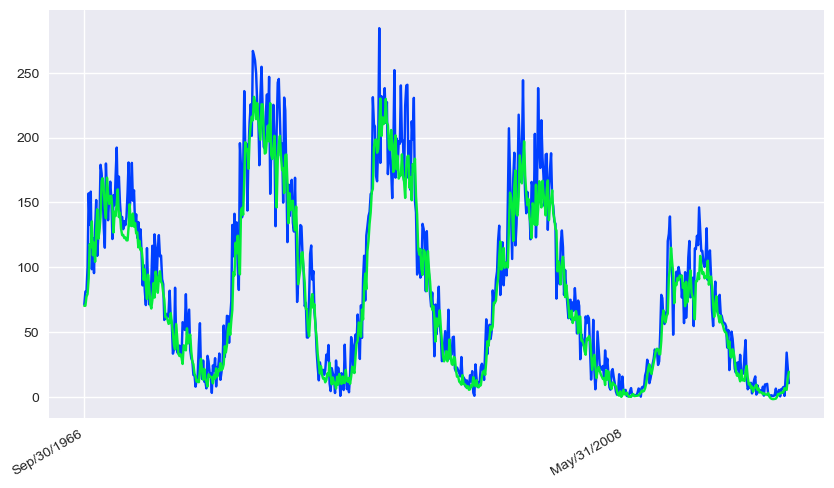

In [51]:
results = np.array(forecast).squeeze()

plot_series(valid_time, (valid_data_values, results))

In [52]:
def model_forecast(model, test, window_size, batch_size):
    """Generates predictions 

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(test)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [53]:
test = data_values[split-window_size: -1]

forecast = model_forecast(model, test, window_size, batch_size)
predictions =  forecast.squeeze()

21/21 [==============================] - 1s 14ms/step


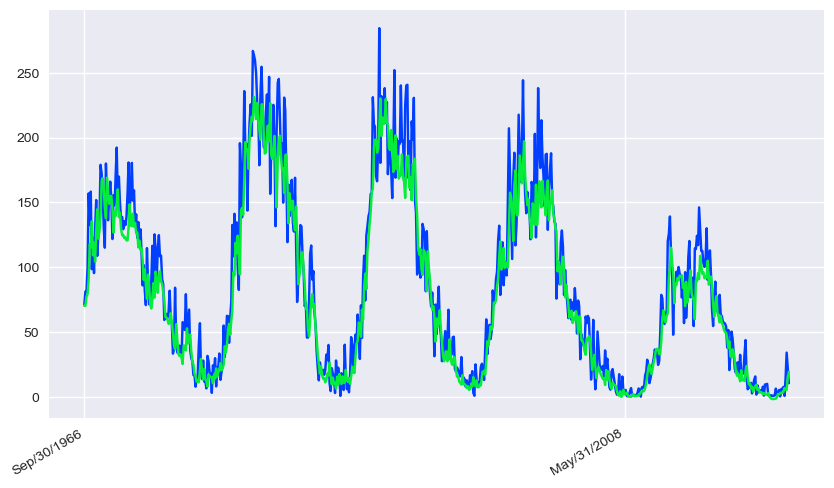

In [54]:
plot_series(valid_time, (valid_data_values, predictions ))

In [55]:
print(tf.keras.metrics.mean_absolute_error(valid_data_values, predictions).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_data_values, results).numpy())

16.419535
16.419533
